In [3]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [4]:
class Linear(layers.Layer):
    '''
    Class for initializing a Layer in Neural Network
    '''
    def __init__(self, units=32):
        '''
        constructor
        :param units:  number of nodes in the layer
        '''
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        '''
        Initializes the weight and bias values of the layer
        :param w:  weights
        :param b:  bias
        '''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        '''
        layer output
        '''
        return tf.matmul(inputs, self.w) + self.b

In [29]:
class MLPBlock(layers.Layer):
'''
Neural Network Block
'''
    def __init__(self):
        '''
        Architecture of the neural network i.e.
        number of layers and nodes in each layer
        '''
        super(MLPBlock, self).__init__()
        self.layers = []     
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))

    def call(self, inputs):
        '''
        Forward pass of the neural network
        '''
        inputs = tf.reshape(inputs, (inputs.shape[0], -1))
        x = self.layers[0](inputs)
        x = tf.nn.relu(x)
        x = self.layers[1](x)
        x = tf.nn.relu(x)
        x = self.layers[2](x)
        return tf.math.sigmoid(x)

In [34]:
net = MLPBlock()
# mnist = tf.keras.datasets.mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
# batches_x_train = np.split(x_train, 20)
# batches_y_train = np.split(y_train, 20)
# batches_x_test = np.split(x_test, 20)
# batches_y_test = np.split(y_test, 20)
# print(len(batches_x_train), len(batches_y_train))
# print(len(batches_x_test), len(batches_y_test))

In [35]:
'''
Load data
'''
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255


#collect all the labels generated for each task in following lists
train_labels = []
test_labels = []

#for each task, initialize y=1 if task_number == label
for index in range(10):
    train_labels.append([1 if x == index else 0 for x in y_train])
    test_labels.append([1 if x == index else 0 for x in y_test])
        
# y_train = np.zeros((train_labels.size, 10))
# y_train[np.arange(train_labels.size), train_labels] = 1

# y_test = np.zeros((test_labels.size, 10))
# y_test[np.arange(test_labels.size), test_labels] = 1

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64)

task: 0
y: tf.Tensor(0, shape=(), dtype=int32)


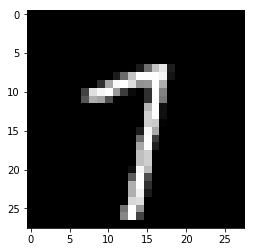

y_train: 5


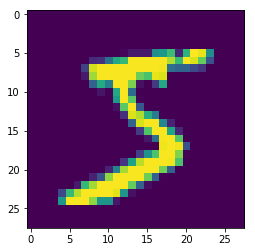

task: 1
y: tf.Tensor(0, shape=(), dtype=int32)


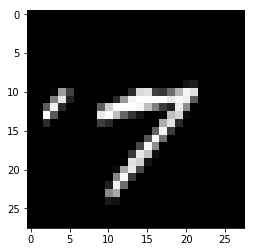

y_train: 5


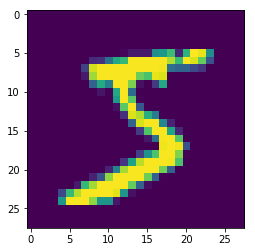

In [27]:
'''
Test code
'''

count = 0
for task in range(10):  
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels[task]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
    for x,y in train_dataset:
#         print('in the batch: %s; %s' % (y[0], x[0]))
#         print('x_train:', x_train[0] == x[0])
        print('task:', task)
        print('y:', y[0])
        plt.imshow(np.asarray(x[0]).reshape(28,28), cmap='gray')
        plt.show()
        print('y_train:', y_train[0])
        plt.imshow(x_train[0].reshape(28,28))
        plt.show()
        break
    count +=1
    if count == 2:
        break
    

## Check for loss_metric in following cell

In [36]:
n_epochs = 5
train_losses = []
test_losses = []
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
bce = tf.keras.losses.BinaryCrossentropy()
loss_metric = tf.keras.metrics.Mean()

for epoch in range(3):
    for task in range(10):
        #  for each task, form a dataloader that shuffles and divides data into batches
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels[task]))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels[task]))
        test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64)
        
        # declare new loss metric for each task to avoid overriding
        loss_metric = tf.keras.metrics.Mean()
        for x_batch_train, y_batch_train in train_dataset:
            with tf.GradientTape() as tape:
                output = net(x_batch_train)
                # Compute training loss
                loss = bce(y_batch_train, output)
                loss += sum(net.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))
            loss_metric(loss)
        train_losses.append(loss_metric.result())
        print('mean train loss after %s task: %s' % (task, train_losses[-1]))
        
        # declare new loss function for testing to avoid overriding
        loss_metric = tf.keras.metrics.Mean()
        for x_batch_test, y_batch_test in test_dataset:
            test_output = net(x_batch_test)
            test_loss = bce(y_batch_test, test_output)
            test_loss += sum(net.losses)
            loss_metric(test_loss)
        test_losses.append(loss_metric.result())
        print('mean test loss after %s task: %s' % (task, test_losses[-1]))
        print('---------------------------------\n')


    

mean train loss after 0 task: tf.Tensor(0.027965808, shape=(), dtype=float32)
mean test loss after 0 task: tf.Tensor(0.014667595, shape=(), dtype=float32)
---------------------------------

mean train loss after 1 task: tf.Tensor(0.02896808, shape=(), dtype=float32)
mean test loss after 1 task: tf.Tensor(0.0111438455, shape=(), dtype=float32)
---------------------------------

mean train loss after 2 task: tf.Tensor(0.050475266, shape=(), dtype=float32)
mean test loss after 2 task: tf.Tensor(0.028386733, shape=(), dtype=float32)
---------------------------------

mean train loss after 3 task: tf.Tensor(0.060712706, shape=(), dtype=float32)
mean test loss after 3 task: tf.Tensor(0.024033112, shape=(), dtype=float32)
---------------------------------

mean train loss after 4 task: tf.Tensor(0.046022546, shape=(), dtype=float32)
mean test loss after 4 task: tf.Tensor(0.01937998, shape=(), dtype=float32)
---------------------------------

mean train loss after 5 task: tf.Tensor(0.052732054

In [37]:
acc = 0
total = 0
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels[0]))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64)
for x_batch_test, y_batch_test in test_dataset:
    test_output = net(x_batch_test)
    for (output,target) in zip(test_output, test_labels[0]):
#         if tf.math.argmax(output) == tf.math.argmax(y_batch_test[index]):
        if output == target:
            acc += 1
        total += 1
print('average accuracy:', acc/total)

average accuracy: 0.0
